# Лабораторная работа №5

## Сети с обратными связями

## Вариант 23
Целью работы является исследование свойств сетей Хопфилда, Элмана, алгоритмов обучения, а также применение сетей в задачах распознавания статических и динамических образов.

## Часть 1

## Распознавание динамических образов.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

/home/prota/Neuroinformatics_labs/env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Реализую слой Элмана.

In [2]:
class ElmanLayer(nn.Module):
    def __init__(self, in_dim, out_dim, activation):
        super(ElmanLayer, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.activation = activation

        self.w1 = torch.nn.Parameter(torch.randn((in_dim, out_dim)))
        self.b = torch.nn.Parameter(torch.randn(out_dim))
        self.w2 = torch.nn.Parameter(torch.randn((out_dim, out_dim)))
        self.m = torch.zeros(out_dim)
        # print(self.m.shape)
    
    def clear_memory(self):
        self.m = torch.zeros(self.out_dim)

    def forward(self, input):
        output = torch.matmul(input, self.w1)
        # print(self.m.shape)
        # print(self.w2.shape)
        d = torch.matmul(self.m, self.w2)
        # print(d.shape)
        output = torch.add(output, d)
        # print(output.shape)
        output = torch.add(output, self.b)
        # print(output.shape)
        output = self.activation(output)
        # print(output.shape)

        self.m = output.clone().detach()
        return output

Сгенерирую сигнал.

In [3]:
def gen_signal(h):
    def p1(k):
        return np.sin(4*np.pi*k)
    def p2(k):
        return np.sin(-2*k**2+7*k)

    target_x = np.arange(0.01, 2.96, h)
    target_tile = p2(target_x)
    main_x = np.arange(0, 1, h)
    main_tile = p1(main_x)

    durations = [3, 4, 6]
    signal = np.concatenate((np.tile(main_tile, durations[0]), target_tile))
    signal = np.concatenate((signal, np.tile(main_tile, durations[1])))
    signal = np.concatenate((signal, target_tile))
    signal = np.concatenate((signal, np.tile(main_tile, durations[2])))
    labels = np.array([-1]*durations[0]*len(main_tile))
    labels = np.concatenate((labels, np.array([1]*len(target_tile))))
    labels = np.concatenate((labels, [-1]*durations[1]*len(main_tile)))
    labels = np.concatenate((labels, np.array([1]*len(target_tile))))
    labels = np.concatenate((labels, [-1]*durations[2]*len(main_tile)))
    return signal, labels

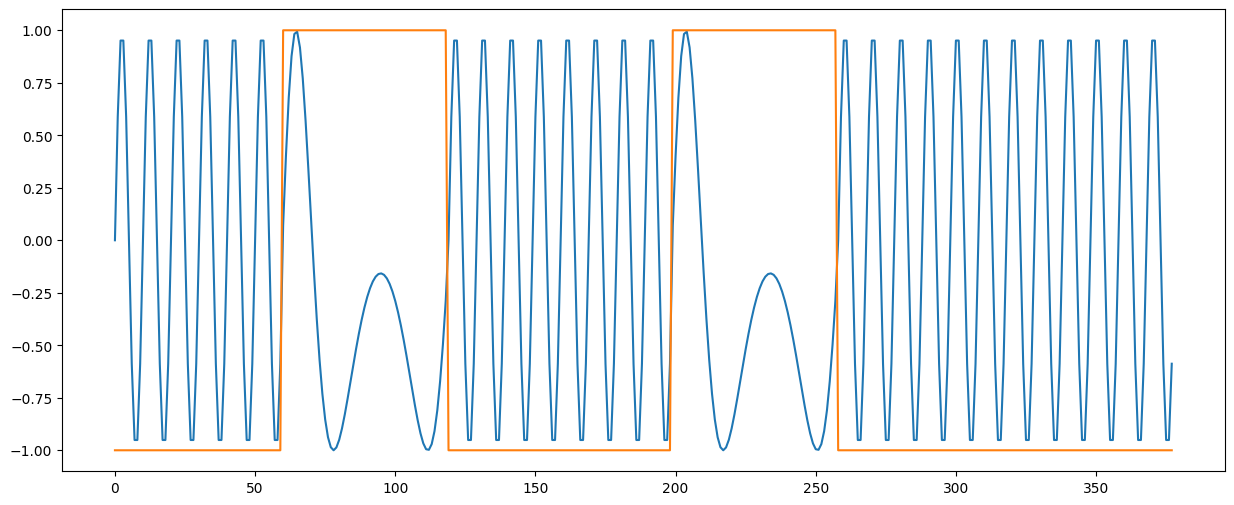

In [4]:
window = 4
signal, labels = gen_signal(0.05)
x = np.array([i for i in range(len(signal))])

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.plot(x, signal)
ax.plot(x, labels)

plt.show()

In [5]:
def make_train_data(signal, labels, window):
    train_signal = [np.array(signal[i:i+window], dtype = np.float32) for i in range(len(signal)-window)]
    train_labels = [np.array(labels[i:i+window], dtype = np.float32) for i in range(len(labels)-window)]

    return [(x, y) for x, y in zip(train_signal, train_labels)]

train_data = make_train_data(signal, labels, window)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=1, shuffle=False)

Построю нейросеть с рекуррентным слоем. Обучу ее.

In [7]:
model = nn.Sequential(
    ElmanLayer(window, 8, nn.Tanh()),
    nn.Linear(8, window)
)

optimizer = optim.Adam(model.parameters(), lr = 1e-3)
model.train()
None

torch.Size([8])


In [12]:
epochs = 100
history = []

model.train()
for i in range(epochs):
    model[0].clear_memory()

    losses = []

    progress_tqdm = tqdm(enumerate(train_loader))

    for j, (input, output_gt) in progress_tqdm:
        output = model(input)

        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(output_gt, output))
        losses += [loss.item()]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    history += [np.mean(losses)]

374it [00:01, 293.98it/s]
374it [00:00, 535.60it/s]
374it [00:00, 833.49it/s]
374it [00:00, 840.14it/s]
374it [00:00, 628.92it/s]
374it [00:00, 523.55it/s]
374it [00:00, 492.46it/s]
374it [00:00, 717.04it/s]
374it [00:00, 578.74it/s]
374it [00:00, 584.88it/s]
374it [00:00, 530.25it/s]
374it [00:00, 723.28it/s]
374it [00:00, 664.92it/s]
374it [00:00, 710.56it/s]
374it [00:00, 615.43it/s]
374it [00:00, 644.52it/s]
374it [00:00, 683.58it/s]
374it [00:00, 659.26it/s]
374it [00:00, 556.57it/s]
374it [00:00, 568.27it/s]


Взгляну на результаты распознавания.

In [13]:
model.eval()
model[0].clear_memory()

predictions = []
for input, output_gt in train_loader:
    predictions += [model(input).detach().numpy()]
predictions = np.array(predictions)
predictions[predictions >= 0] = 1
predictions[predictions < 0] = -1

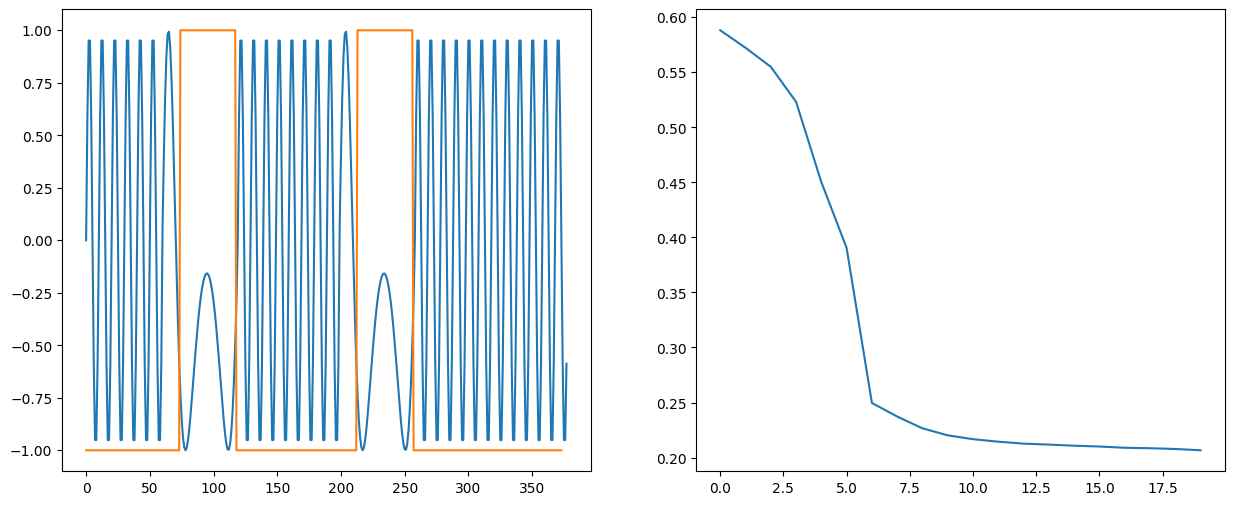

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].plot(x, signal)
ax[0].plot(x[:-4], predictions[:, 0, 0])

ax[1].plot(history)

plt.show()